# Structure of the Data

# Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm, trange
import time
import seaborn as sns
from scipy.stats import skew, zscore


# SCIKIT - LEARN
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA


# PYTORCH (for neural networks)
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split, Subset
import torch.optim as optim
from torchvision import transforms
import torchvision.models as models
import torch.nn as nn

# SHAP
import shap



# XGBoost
import xgboost as xgb
from sklearn.linear_model import ElasticNet

## Connexion to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Import home-made classes

In [ ]:
!cp '/content/drive/MyDrive/ML BigProject/library.py' /content/
from library import preprocess_Ad_Table_Trim, DVMdataset

Both processing classes will be in the PY file

# Data importation

In [ ]:
# For classical data
Ad_table = pd.read_csv('/content/drive/MyDrive/ML BigProject/data/Ad_table (extra).csv')
Trim = pd.read_csv('/content/drive/MyDrive/ML BigProject/data/Trim_table.csv')

# For images
Price_table = pd.read_csv("/content/drive/MyDrive/ML BigProject/data/Price_table.csv")
Images_table = pd.read_csv("/content/drive/MyDrive/ML BigProject/data/Image_table.csv", sep = ',')
autosWithNames = pd.read_csv("/content/drive/MyDrive/ML BigProject/data/autosWithNames.csv", sep=",")


# Run the hand-made preprocessing class
preprocess_classical_data = preprocess_Ad_Table_Trim(Ad_table, Trim)

# Constant parameters

In [ ]:
RANDOM_STATE = 999

# Columns we decided to remove, after the Descriptive statistics part
columns_to_drop = ['Maker',
                    'Genmodel',
                    'Genmodel_ID',
                    'Adv_ID',
                    'Adv_year',
                    'Adv_month',
                    'Reg_year',
                    'Annual_Tax',
                    'Color',

                    "Body_type_0",
                   "Body_type_2",
                   "Body_type_3",
                   "Body_type_10",
                   "Body_type_11",
                   "Body_type_12",
                   "Body_type_13",
                   "Body_type_16",
                   "Body_type_17",
                   "Gear_box_2",
                   "Gear_box_3",
                   "Fuel_type_2",
                   "Fuel_type_3",
                   "Fuel_type_11",
                   "Fuel_type_12",
                   "Fuel_type_13"]

# Descriptive statistics

In [ ]:
y, X = preprocess_Ad_Table_Trim(Ad_table, Trim).final_set(
                one_hot_encoder = False,
                standardization = False,
                remove_outliers = False)

In [ ]:
df = pd.concat([y, X], axis=1)

In [ ]:
df.columns

In [ ]:
df.shape

In [ ]:
df.describe()

## Analysis of the outliers

### Outliers on the target variable, the price

In [ ]:
y, X = preprocess_Ad_Table_Trim(Ad_table, Trim).final_set(
                one_hot_encoder = False,
                standardization = False,
                remove_outliers = False)

In [ ]:
skewness = skew(df['Price'])

plt.figure(figsize=(12, 6))
sns.histplot(df.Price, bins=150, kde=True, color='skyblue', stat='density')

# We add vertical lines for mean and the skewness
plt.axvline(np.mean(df.Price), color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(skewness, color='green', linestyle='dashed', linewidth=1, label='Skewness')

plt.title('Distribution of a Skewed Variable with Skewness')
plt.xlabel('Variable Value')
plt.ylabel('Density')
plt.legend()
plt.show()

print(f"Skewness: {skewness}")

"""sns.displot(df, x="Price", color='#e3543b')
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.show()"""

In [ ]:
df.sort_values(by='Price', ascending=False).head(10)


In [ ]:
percentile_99 = df["Price"].quantile(0.99)
df_99 = df[df["Price"] <= percentile_99]

sns.displot(df_99, x="Price", color='#e3543b')
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.show()

In [ ]:
df_99.sort_values(by='Price', ascending=False).head(10)

### Outliers in the dataset: cleaning with the zscore

In [ ]:
z_scores = zscore(df)
df = df[(abs(z_scores) < 4).all(axis=1)]

In [ ]:
df.sort_values(by='Price', ascending=False).head(10)

## Analyse des NaN

In [ ]:
df_na = preprocess_Ad_Table_Trim(Ad_table, Trim).get_full_data()

In [ ]:
df_na['nan_count_per_observation'] = df_na.isnull().sum(axis=1)

In [ ]:
sns.histplot(data=df_na, x="nan_count_per_observation", color="navy", bins=15)

In [ ]:
nan_count_per_variable = df_na.isnull().sum()
nan_count_per_variable

In [ ]:
nan_count_table = pd.DataFrame({'Variable': nan_count_per_variable.index, 'NaN Count': nan_count_per_variable.values})
nan_count_table = nan_count_table[nan_count_table['NaN Count']>0].sort_values(by='NaN Count', ascending=False)

plt.barh(nan_count_table['Variable'], nan_count_table['NaN Count'], color='skyblue')

We decided to delete the columns : Annual_Tax and Color because it was with lot of NaN and it doesn't really have an impact on the price

## Distribution

### Distribution of each variable

We now analyse the final dataset for the graphs

In [ ]:
y, X = preprocess_Ad_Table_Trim(Ad_table, Trim).final_set(
                one_hot_encoder = False,
                standardization = False)

df = pd.concat([y, X], axis=1)

In [ ]:
df.hist(bins=100, figsize=(10, 8), color='#e3543b')
plt.suptitle('Distribution of each variable in the dataset', x=0.5, y=1.02, fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
sns.boxplot(x='Price', data=df, color='#e3543b')
plt.title('Distribution of the target variable, the price')
plt.xlabel('Price')
plt.show()

### Relationship between the dependant variable and the independent variables

#### Float variables

In [ ]:
variables_numeriques = ['Runned_Miles', 'Engin_size', 'Engine_power', 'Wheelbase', 'Height', 'Width', 'Length', 'Average_mpg', 'Gas_emission', 'Top_speed']

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
fig.suptitle('Scatter plots of Price with each variable')

for i, variable in enumerate(variables_numeriques):
    if i < 10:
        row = i // 4
        col = i % 4
        sns.scatterplot(x=variable, y='Price', data=df, ax=axes[row, col], color='#e3543b', alpha=0.7)
        axes[row, col].set_title(f'{variable} vs Price', fontsize=12)
        axes[row, col].set_xlabel(variable, fontsize=10)
        axes[row, col].set_ylabel('Price', fontsize=10)
        axes[row, col].tick_params(axis='both', which='both', labelsize=8)
    else:
        fig.delaxes(axes.flatten()[i])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Integers variables

In [ ]:
sns.boxplot(x='Price', y='Seat_num', data=df, orient='h', palette="colorblind")
plt.title('Boxplot of prices depending on the number of seats')
plt.xlabel('Price')
plt.ylabel('Number of Seats')
plt.show()

In [ ]:
sns.boxplot(x='Price', y='Door_num', data=df, orient='h', palette="colorblind")
plt.title('Boxplot of prices depending on the number of doors')
plt.xlabel('Price')
plt.ylabel('Number of Doors')
plt.show()

#### Qualitative variables

In [ ]:
sns.boxplot(x='Price', y='Gear_box', data=df, orient='h', palette="colorblind")
plt.title('Box plot of prices depending on the gear box')
plt.ylabel('Gear box')
plt.xlabel('Price')
plt.show()

In [ ]:
sns.boxplot(x='Price', y='Fuel_type', data=df, orient='h', palette="colorblind")
plt.title('Box plot of prices depending on the fuel type')
plt.ylabel('Fuel type')
plt.xlabel('Price')
plt.show()

In [ ]:
sns.boxplot(x='Price', y='Body_type', data=df, orient='h', palette="colorblind")
plt.title('Boxplot of prices depending on body type')
plt.xlabel('Price')
plt.ylabel('Body type')
plt.show()

## Correlation matrix

In [ ]:
y, X = preprocess_Ad_Table_Trim(Ad_table, Trim).final_set(
                standardization=True,
                remove_outliers=True,
                columns_to_drop=columns_to_drop)

In [ ]:
correlation_matrix = X.corr()

plt.figure(figsize=(25, 10))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation matrix')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
plt.show()

# Machine learning models

## Classical data

### XGBoost

#### **Setting Data**

In [ ]:
# Read data
Ad_table = pd.read_csv('/content/drive/MyDrive/ML BigProject/data/Ad_table (extra).csv')
Trim = pd.read_csv('/content/drive/MyDrive/ML BigProject/data/Trim_table.csv')
preprocess_data = preprocess_Ad_Table_Trim(Ad_table, Trim)

# Apply self-made function and obtain cleaned data
y, X = preprocess_data.final_set(remove_outliers=True, standardization=False, columns_to_drop = columns_to_drop)

# Create numpy arrays
X_values = X.values
y_values = y.values

In [ ]:
# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, random_state = RANDOM_STATE, test_size = 0.15)

# Train-Validation-Split for the initial XGBoost Model
X_train_init, X_val, y_train_init, y_val = train_test_split(X_train, y_train, random_state = RANDOM_STATE, test_size = 0.15)

# 72% training data
# 12.75% validation data
# 15% test data

#### **Model Training**

##### ***A) Train Baseline XGBoost Model***

In [ ]:
# Define initial XGB model to obtain optimal number of estimators (trees) for a given learning rate eta
xgb_init = xgb.XGBRegressor(objective = "reg:squarederror", # Objective function to be minimized by XGBoost model
                            eval_metric="rmse",
                            base_score = 0.5, # Initial prediction score for all observations (default value).
                            booster = "gbtree", # Boosting type, here gradient boosting tree
                            learning_rate = 0.1, # Learning rate of XGBoost model determining the speed of convergence (default value)
                            n_estimators = 5000, # Number of trees to be estimated. Here, set to very high (unreached) number because stopped by early_stopping_rounds.
                            max_depth = 8, # Maximum tree depth (default value = 6). Since we have p=14>6, we allow tree depth up to 8 levels. To be tuned later.
                            min_child_weight = 1, # Minimum number of instances needed per child (default value). To be tunded later.
                            reg_lambda = 1, # L2 regularization parameter scaling the similiratiy scores and controlling for nodes containing only few parameters. To be tuned later.
                            gamma = 0.1, # Similiarity score threshold (pruning parameter) to create new split. To be tuned later.
                            early_stopping_rounds = 500, # Number of iterations in which validation metric needs to improve at least once to continue model training (10% of total iterations)
                            subsample = 0.8, # Sample size of training data to be used at each iteration. To be tuned, later.
                            sampling_method = "uniform", # Determines distribution from which subsample is randomly drawn.
                            importance_type = "gain", # Criteria for the model's feature_importance property
                            n_jobs = 7, # Number of CPU kernels to be used for model training (time reduction)
                            verbosity = 2,
                            random_state = 999
                            )

# Fit model and obtain RMSE using cross-validation (eval_set)
xgb_init.fit(X_train_init, y_train_init, eval_set = [(X_train_init, y_train_init), (X_val, y_val)])

In [ ]:
# Evaluate model performance, feature importance
xgb_init.best_score, xgb_init.feature_importances_

In [ ]:
# Visualize Evaluation of RMSE and optimal number of estimators for the given learning rate
print(f'Optimal number of estimators: {xgb_init.best_iteration}'),
# Visualization
results = xgb_init.evals_result()
plt.figure(figsize=(6, 4))
plt.plot(results["validation_0"]["rmse"], label="Training RMSE")
plt.plot(results["validation_1"]["rmse"], label="Validation RMSE")
plt.axvline(xgb_init.best_iteration, color="gray", label="Optimal number of estimators")
plt.xlabel("Number of trees")
plt.ylabel("RMSE")
plt.legend()

In [ ]:
# Predict test data set to have benchmark for model performance
y_pred_init = xgb_init.predict(X_test)
rmse_init = np.sqrt(mean_squared_error(y_test, y_pred_init))
r2_init = r2_score(y_test, y_pred_init)

rmse_init, r2_init

For the given learning rate of 0.1, our initial XGBoost model estimates 765 trees to obtain its best predictions. The final model performance, measured by evaluating predictions on the test sample, shows an asbolute mean error of 1454.62 and an R2 score of 0.9781. Thus, the default hyperparameter specifications of our first model already provide very good predicitons which is in line with the overall high predicition power of the XGBoost algorithm. Especially the R2 score indicates that our baseline model explains most of the variance (97.68%) of our target variable.

##### ***B) Model Tuning***

###### ***Step 1: Tuning Tree Depth and Child Weight*** <br/>

To improve our baseline model, we start by tuning the hyperparameters of max_depth and min_child_weight as they have the biggest impact on growing the xgbtrees.


In [ ]:
# Define xgb_grid model for parameter tuning with n_estimators = 624 and without early_stopping_rounds
xgb_grid = xgb.XGBRegressor(objective = "reg:squarederror", # Objective function to be minimized by XGBoost model
                            eval_metric="rmse",
                            base_score = 0.5, # Initial prediction score for all observations (default value).
                            booster = "gbtree", # Boosting type, here gradient boosting tree
                            learning_rate = 0.1, # Learning rate of XGBoost model determining the speed of convergence (default value)
                            n_estimators = 765, # Optimal number of estimators for given learning rate of 0.1
                            max_depth = 8, # Maximum tree depth (to be tuned)
                            min_child_weight = 1, # Minimum number of instances needed per child (to be tuned)
                            reg_lambda = 1,  # L2 regularization parameter scaling the similiratiy scores and controlling for nodes containing only few parameters (to be tuned)
                            gamma = 0.1, # Similiarity score threshold (pruning parameter) to create new split (to be tuned)
                            subsample = 0.8, # Sample size of training data to be used at each iteration (to be tuned)
                            sampling_method = "uniform", # Determines distribution from which subsample is randomly drawn.
                            importance_type = "gain", # Criteria for the model's feature_importance property
                            n_jobs = 7, # Number of CPU kernels to be used for model training (time reduction)
                            verbosity = 2,
                            random_state = 999
                            )

In [ ]:
# Define first parameter grid for max_depth and min_child_weight
param_grid1 = {"max_depth" : [2, 4, 6, 12],
               "min_child_weight" : [1, 2, 6, 10]
               }

# Define Grid search model
xgb1 = GridSearchCV(estimator = xgb_grid,
                    param_grid = param_grid1,
                    scoring = ["neg_root_mean_squared_error", "r2"],
                    refit = "neg_root_mean_squared_error", # Define metric according to which the model's parameters will be set after the grid search (to directly use xgb1 for predicting)
                    cv = 4,
                    verbose = 3,
                    return_train_score = True, # Set to true such that the cv_results will also include the training error scores
                    )

# Fit model
xgb1.fit(X_train, y_train)

In [ ]:
xgb1.best_params_, xgb1.best_score_

In [ ]:
y_pred1 = xgb1.predict(X_test)
rmse_1 = np.sqrt(mean_squared_error(y_test ,y_pred1))
r2_1 = r2_score(y_test, y_pred1)

rmse_1, r2_1

###### ***Step 1.1: Serach for optimal Tree Depth*** <br/>
In a next step, we search for potentially better values for the tree depth and child weight, by searching around the best parameters from the previous step.

In [ ]:
# Define first parameter grid for max_depth and min_child_weight
param_grid1_1 = {"max_depth" : [5, 6, 7],
                 "min_child_weight" : [1 ,2]
               }

# Define Grid search model
xgb1_1 = GridSearchCV(estimator = xgb_grid,
                    param_grid = param_grid1_1,
                    scoring = ["neg_root_mean_squared_error", "r2"],
                    refit = "neg_root_mean_squared_error", # Define metric according to which the model's parameters will be set after the grid search (to directly use xgb1 for predicting)
                    cv = 4,
                    verbose = 3,
                    return_train_score = True, # Set to true such that the cv_results will also include the training error scores
                    )

# Fit model
xgb1_1.fit(X_train, y_train)

In [ ]:
xgb1_1.best_params_, xgb1_1.best_score_

In [ ]:
y_pred1_1 = xgb1_1.predict(X_test)
rmse_1_1 = np.sqrt(mean_squared_error(y_test ,y_pred1_1))
r2_1_1 = r2_score(y_test, y_pred1_1)

rmse_1_1, r2_1_1

We can see, that for the given learning rate and number of estimators, the optimal tree depth is 7 and the the optimal minimum child weight is 1. Using these paraemeters, we can observe that our error metric slightly decreased by approx. 30 points. We can also observe a slight improvement in prediction accuracy.

###### ***Step 2: Tuning Gamma***

In [ ]:
# Define second parameter grid
param_grid2 = {"gamma" : [0, 00.1, 0.1, 1, 10, 100]

}

# Define Grid search model
# Define Grid search model
xgb2 = GridSearchCV(estimator = xgb1_1.best_estimator_,
                    param_grid = param_grid2,
                    scoring = ["neg_root_mean_squared_error", "r2"],
                    refit = "neg_root_mean_squared_error", # Define metric according to which the model's parameters will be set after the grid search (to directly use xgb1 for predicting)
                    cv = 4,
                    verbose = 3,
                    return_train_score = True, # Set to true such that the cv_results will also include the training error scores
                    )

# Fit model
xgb2.fit(X_train, y_train)

In [ ]:
xgb2.best_params_, xgb2.best_score_

In [ ]:
y_pred2 = xgb2.predict(X_test)
rmse_2 = np.sqrt(mean_squared_error(y_test ,y_pred2))
r2_2 = r2_score(y_test, y_pred2)

rmse_2, r2_2

We can observe that our initial gamma value of 0.1 did not enhance the model performance. Setting the scoring threshold to create a new child node to 0 yields the same predictive power. This is surprising, since the child weight is set to a quite low value and thus model overfitting should be expected. However, cross validating over values on child weight and gamma suggest more complex trees. An explanation herefore, might be that the tree depth regulates the tree complexity sufficiently.

###### ***Step 3: Tuning Subsample Size***

In [ ]:
# Define third parameter grid
param_grid3 = {"subsample" : [0.5, 0.6, 0.7, 0.8, 0.9, 1]
               }

# Define Grid search model
xgb3 = GridSearchCV(estimator = xgb2.best_estimator_,
                    param_grid = param_grid3,
                    scoring = ["neg_root_mean_squared_error", "r2"],
                    refit = "neg_root_mean_squared_error", # Define metric according to which the model's parameters will be set after the grid search (to directly use xgb1 for predicting)
                    cv = 4,
                    verbose = 3,
                    return_train_score = True, # Set to true such that the cv_results will also include the training error scores
                    )

# Fit model
xgb3.fit(X_train, y_train)

In [ ]:
xgb3.best_params_, xgb3.best_score_

In [ ]:
y_pred3 = xgb3.predict(X_test)
rmse_3 = np.sqrt(mean_squared_error(y_test, y_pred3))
r2_3 = r2_score(y_test, y_pred3)

rmse_3, r2_3

###### ***Step 4: Tuning L2 Regularization Parameter Lambda***

In [ ]:
# Define fourth parameter grid
param_grid4 = {"reg_lambda" : [0, 1, 2, 3, 4, 5, 10, 20, 40, 80, 120, 160]
               }

# Define Grid search model
xgb4 = GridSearchCV(estimator = xgb3.best_estimator_,
                    param_grid = param_grid4,
                    scoring = ["neg_root_mean_squared_error", "r2"],
                    refit = "neg_root_mean_squared_error",
                    n_jobs = 7, # Define number of CPU cores to use on your machine
                    cv = 4,
                    verbose = 3,
                    return_train_score = True, # Set to true such that the cv_results will also include the training error scores
                    )

# Fit model
xgb4.fit(X_train, y_train)

In [ ]:
xgb4.best_params_, xgb4.best_score_

In [ ]:
y_pred4 = xgb4.predict(X_test)
rmse_4 = np.sqrt(mean_squared_error(y_test, y_pred4))
r2_4 = r2_score(y_test, y_pred4)

rmse_4, r2_4

As we can see, increasing the L2 regularization parameter lamda slightly improves our model performance. To obtain the optimal value for lambda, we conduct a more detailed grid search around the value of 80.

###### ***Step 4.1: Searching for best L2 Regularization Parameter Lambda***

In [ ]:
# Define fourth parameter grid
param_grid4_1 = {"reg_lambda" : [1.5, 1.75, 2, 2.25, 2.5]
               }

# Define Grid search model
xgb4_1 = GridSearchCV(estimator = xgb3.best_estimator_,
                    param_grid = param_grid4_1,
                    scoring = ["neg_root_mean_squared_error", "r2"],
                    refit = "neg_root_mean_squared_error",
                    n_jobs = 7, # Define number of CPU cores to use on your machine
                    cv = 4,
                    verbose = 3,
                    return_train_score = True, # Set to true such that the cv_results will also include the training error scores
                    )

# Fit model
xgb4_1.fit(X_train, y_train)

In [ ]:
xgb4_1.best_params_, xgb4_1.best_score_

In [ ]:
y_pred4_1 = xgb4_1.predict(X_test)
rmse_4_1 = np.sqrt(mean_squared_error(y_test, y_pred4_1))
r2_4_1 = r2_score(y_test, y_pred4_1)

rmse_4_1, r2_4_1

As we can see, the negative RMSE decreased 3 points by setting lambda from 80 to 70. However, the mean absolute error for the test data predictions increased by 20 points. Thus, we decide to keep the lambda value at 70.

##### ***Evaluation of Hyperparameter Tuning***

In [ ]:
# Create lists with respective error values

# Error Metrics
neg_rmse_train = [np.min(xgb1_1.cv_results_["mean_train_neg_root_mean_squared_error"]), np.min(xgb2.cv_results_["mean_train_neg_root_mean_squared_error"]), np.min(xgb3.cv_results_["mean_train_neg_root_mean_squared_error"]), np.min(xgb4_1.cv_results_["mean_train_neg_root_mean_squared_error"])]
rmse_train = -1 * np.array(neg_rmse_train)
neg_rmse_cv = [xgb1_1.best_score_, xgb2.best_score_, xgb3.best_score_, xgb4_1.best_score_]
rmse_cv = -1 * np.array(neg_rmse_cv)
rmse_test = [rmse_1_1, rmse_2, rmse_3, rmse_4_1]

# R2 Scores
r2_train = [np.min(xgb1_1.cv_results_["mean_train_r2"]), np.min(xgb2.cv_results_["mean_train_r2"]), np.min(xgb3.cv_results_["mean_train_r2"]), np.min(xgb4_1.cv_results_["mean_train_r2"])]
r2_cv = [np.min(xgb1_1.cv_results_["mean_test_r2"]), np.min(xgb2.cv_results_["mean_test_r2"]), np.min(xgb3.cv_results_["mean_test_r2"]), np.min(xgb4_1.cv_results_["mean_test_r2"])]
r2_test = [r2_1_1, r2_2, r2_3, r2_4_1]

# Custom X-Label according to tuning step
tuning_step = [1, 2, 3, 4]

In [ ]:
# Create 1x3 figure grid for model performance in terms of error metric
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
axes[0].set_title("Training Error by Tuning Step")
axes[0].plot(tuning_step, rmse_train, marker = ".", label = "RMSE CV")
axes[0].set_xticks(tuning_step)
axes[0].set_xlabel("Tuning Step (XGB Version)")
axes[0].set_ylabel("RMSE")
axes[0].legend()

axes[1].set_title("Validation Error by Tuning Step")
axes[1].plot(tuning_step, rmse_cv, marker = ".", label = "RMSE CV", color = "green")
axes[1].set_xticks(tuning_step)
axes[1].set_xlabel("Tuning Step (XGB Version)")
axes[1].set_ylabel("RMSE")
axes[1].legend()

axes[2].set_title("Test Error by Tuning Step")
axes[2].plot(tuning_step, rmse_test, marker = ".", label = "RMSE Test", color = "orange")
axes[2].set_xticks(tuning_step)
axes[2].set_xlabel("Tuning Step (XGB Version)")
axes[2].set_ylabel("RMSE")
axes[2].legend()


In [ ]:
# Create 1x3 figure grid for model performance in terms of error metric
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
axes[0].set_title("Training R2-Score by Tuning Step")
axes[0].plot(tuning_step, r2_train, marker = ".", label = "R2 Training")
axes[0].set_xticks(tuning_step)
axes[0].set_xlabel("Tuning Step (XGB Version)")
axes[0].set_ylabel("R2 Score")
axes[0].legend()

axes[1].set_title("Cross Validation R2-Score by Tuning Step")
axes[1].plot(tuning_step, r2_cv, marker = ".", label = "R2 CV", color = "green")
axes[1].set_xticks(tuning_step)
axes[1].set_xlabel("Tuning Step (XGB Version)")
axes[1].set_ylabel("R2 Score")
axes[1].legend()

axes[2].set_title("Test R2-Score by Tuning Step")
axes[2].plot(tuning_step, r2_test, marker = ".", label = "R2 Test", color = "orange")
axes[2].set_xticks(tuning_step)
axes[2].set_xlabel("Tuning Step (XGB Version)")
axes[2].set_ylabel("R2 Score")
axes[2].legend()

Both the respective error metrics and the R2 scroes indicate that every tuning step of the hyperparameters lead only to very little enhancement in model performance. However, the comparison between the validation error (RMSE) and the test error (MAE) as well as the evolution of the Test R2-Score support our decission of choosing the XGBoost Model with lambda set to 80. Even though the model performance increases for the validation sample, decreasing the L2 regularization parameter lambda to 70 yields a relatively strong decrease in model performance for the test sample.

##### ***Final XGBoost Model***

In [ ]:
# Define XGBoost with optimal parameters and fit on complete datset
xgb_agn= xgb.XGBRegressor(objective = "reg:squarederror", # Objective function to be minimized by XGBoost model
                            enable_categorical = True,
                            eval_metric="rmse",
                            base_score = 0.5, # Initial prediction score for all observations (default value).
                            booster = "gbtree", # Boosting type, here gradient boosting tree
                            learning_rate = 0.1, # Learning rate of XGBoost model determining the speed of convergence (default value)
                            n_estimators = 765, # Number of trees to be estimated. Here, set to very high (unreached) number because stopped by early_stopping_rounds.
                            max_depth = 7, # Maximum tree depth (default value = 6). Since we have p=14>6, we allow tree depth up to 8 levels. To be tuned later.
                            min_child_weight = 1, # Minimum number of instances needed per child (default value). To be tunded later.
                            reg_lambda = 1.5, # L2 regularization parameter scaling the similiratiy scores and controlling for nodes containing only few parameters. To be tuned later.
                            gamma = 0, # Similiarity score threshold (pruning parameter) to create new split. To be tuned later.
                            subsample = 1, # Sample size of training data to be used at each iteration. To be tuned, later.
                            sampling_method = "uniform", # Determines distribution from which subsample is randomly drawn.
                            importance_type = "gain", # Criteria for the model's feature_importance property
                            n_jobs = 7, # Number of CPU kernels to be used for model training (time reduction)
                            verbosity = 2,
                            random_state = 999
                            )

xgb_agn.fit(X_train,y_train)

#### ***C) Model Agnostic Methods***

***Basic Variable Importance*** <br/>
First we plot the feature importance based on the default importance criterion which is gain. More precisely, to obtian the feature importance the gain in simliartiy provided by creating a new node (binary split) based on a specific feature is calculated (averaged).

In [ ]:
# Create Bar chart displaying the variable importance for our XGBoost Model
names = X.columns
values_imp = xgb_agn.feature_importances_

plt.figure(figsize=(20,6))
plt.bar(names, values_imp)
plt.xticks(rotation=90)
plt.title("XGBoost Model Variable Importance")
plt.show()

***Partial Dependence Plots***

In [ ]:
# Create background distirbution as reference
X_ref = shap.utils.sample(X, 50000)

# Define features for which we want to plot a pdp
features = X.columns

In [ ]:
# Start loop and create PDPs for desired features
for feature in features:
  shap.partial_dependence_plot(
      ind = feature,
      model = xgb_agn.predict,
      data = X_ref,
      model_expected_value = True,
      feature_expected_value = True,
      ice = True,
      show = True,
      ylabel = f'Marg. change in Price w.r.t. {feature}'
  )

For every feature, the ICE curves follow the same curves, indicating no significant intersction effects between the variables for predicting the car price. Thus, the PDP plor might already be a sufficient globale model-agnostic tool to capture the relationship between our features and the target variable.

***Shapely Values***

In [ ]:
# Import necessary library to display shap plots
from IPython.display import display, Javascript
display(Javascript('initjs()'))

# import javascript visualization library
shap.initjs()

In [ ]:
# Define explainer object for the final XGBoost Model
explainer = shap.TreeExplainer(xgb_agn)

# Compute Shap values for all features using the small subsample X_ref
shap_values = explainer.shap_values(X_ref)

In [ ]:
# Create shap force plot to visualize the first occurance prediction's explanation
shap.force_plot(explainer.expected_value,
                shap_values[0,:],
                X_ref.iloc[0,:],
                matplotlib=True
                #contribution_threshold = # controls features displayed on the plot.
                )

This force graph explains the prediction of our XGBoost model for the first observation in our data. We can observe that for this car, the low milage (13,479) and the high enigine power (335 hp) have a positive influence on the car's price evaluation. In contrast, the relatively low top speed of 155 mp/h and the car's height (high, low, inch, cm, intepretation?) reduce the car's price. While the base value represents the expected value (i.e. average prediction over all input instances), f(x) denotes the observation's predicted price, driven by the red and blue force arrows.

In [ ]:
# Use Beeswarm plot to summarize the shap values (impact on model output) for all features
shap.summary_plot(shap_values, X_ref)

As the summary beeswarm graph shows, we can see that especially engine power, runned miles, height, top speed as well as engine size drive our model results. More precisely, the red and blue colors indicate that our model predicts a higher price for cars with much horse power, few runned miles, a low overall height and high top speed. The plot also displays that cars with many runned miles will be evaluated at a lower price, i.e. high number of runned miles negatively impacts a car's price prediction.

Comparing the Shapely plots with the standard variable importance function from the scikit-learn library, we can see that both approaches determine engine power, top speed, runned miles and height (in descending order) as most significant features for the car price estimation.

#### ***D) Information Reduction Method: Elastic Net***

XGBoost by construction prunes and accounts for its complexity, i.e. controls for overfitting. However, in the following we want to challenge and apply an information reduction method, namely the elastic net. By fitting an elastic net, we can determine the most important variables and refit our XGBoost model using this subselection of features. Again, since the XGBoost algorithm automatically creates its binary splits based on those features providing the most gain in smilarity score, this approach is not expected to improve the model performance but may even slightly worsen our results. The later might happen because we might exclude variables that have low predictive power for a linear model but might be a feature for a chosen candiadate split for the XGBoost. That however is but very rather unlikely.

Since we are in a high dimension case with 33 features, we can apply so called information reduction methods that will reduce the number of features considered in our models. From our correlation matrix, we can observe that features which are logically related to each other like specifictions on the engine or car dimensions show high correlation coefficients. Thus, we can use an elastic net as reduction method which is a combination of the ridge and lasso to obtain the most important features for predicting the car prices. However, before applying the elastic net, we need to standardize the data such that the l1 and l2 penalization are equally applied to all our variables, i.e. all features are on the same scale

In [ ]:
from sklearn.preprocessing import StandardScaler
# Standardize the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Define the hyperparameter grid
param_grid_elastic = {
    'max_iter': [1000],
    'alpha': np.arange(0.0, 1.0, 0.1),
    'l1_ratio': np.arange(0.0, 1.0, 0.1)
}

# Create an ElasticNet model
elastic_reg = ElasticNet(random_state=999)

# Create a GridSearchCV object
elastic = GridSearchCV(estimator = elastic_reg,
                    param_grid = param_grid_elastic,
                    scoring = ["neg_root_mean_squared_error", "r2"],
                    refit = "neg_root_mean_squared_error",
                    n_jobs = 7, # Define number of CPU cores to use on your machine
                    cv = 4,
                    verbose = 3,
                    return_train_score = True, # Set to true such that the cv_results will also include the training error scores
                    )

# Fit the model to the training data
elastic.fit(X_train_scaled, y_train)

# Access the best hyperparameters and the best model
best_params = elastic.best_params_
best_model = elastic.best_estimator_

In [ ]:
best_model

Even though we are aiming to use the elastic net only to determine the relevant variables, we can also predict the car prices and evlaute the linear model's performance. However, as we are not aiming to further improve the model performance, these values provide only an idea of the best elastic net with parameters l2 regularization alpha = 0.1 and l1 = 0.9

In [ ]:
y_pred_elastic = elastic.predict(X_test_scaled)
mae_elastic = mean_squared_error(y_test, y_pred_elastic, squared=False)
r2_elastic  = r2_score(y_test, y_pred_elastic)

mae_elastic, r2_elastic

As to be expected, with an RMSE of 4497.61 and a R2 scor eof 77% the model performance of the elastic net is worse than our more complex, non-linear models, i.e. XGBoost and KNN. However, we can now use the elastic net results to define a new dataset containing only those features which were not set to zero.

In [ ]:
# Supress scientific notation
np.set_printoptions(precision=4, suppress=True)

# Obtain the coefficients for the linear elastic model
coef_elastic = elastic.best_estimator_.coef_
coef_elastic

Since our best model is a mixture of the ridge and lasso models, by construction, we cannot observe any coefficient being set to zero. However, we can observe the difference in magnitude of our coefficients and use a rule of thumb to drop some features. In our case, we decide to drop all coefficients with an absolute value smaller than 200, i.e. 17 features.

In [ ]:
# Create index containing subselection of all features determined by the threshold of 200
selected_features = X.columns[abs(coef_elastic) > 200]

# Define new subset
X_elastic = X[selected_features]
y_elastic = y

In [ ]:
# Create new Test-Train-Split
X_tr, X_te, y_tr, y_te = train_test_split(X_elastic, y_elastic, random_state = 999, test_size = 0.15)

In [ ]:
# Fit the final xgboost model using only the important varibles
xgb_agn.fit(X_tr,y_tr)

In [ ]:
# Predict for test set
y_pred_xgbelastic= xgb_agn.predict(X_te)

# Compute metrics
mae_xgbelastic = mean_squared_error(y_te, y_pred_xgbelastic, squared=False)
rmse_xgbelastic = np.sqrt(mean_squared_error(y_te, y_pred_xgbelastic))
r2_xgbelastic  = r2_score(y_te, y_pred_xgbelastic)

rmse_xgbelastic, r2_xgbelastic

As expected, the model performance slightly decreased when fitting our best xgboost model only with the most important variables, determined by the elastic net. Put differently, by following this approach we provided a computationally more efficient way of predicting car prices (when only using 17 important variables) at the expense of a lower model performance.

### KNN

#### Setting the data

In [ ]:
y, X = preprocess_Ad_Table_Trim(Ad_table, Trim).final_set(
                standardization=True,
                remove_outliers=True,
                columns_to_drop=columns_to_drop)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

#### Setting the model

##### Finding the best hyperparameter

In [ ]:
rmse = []
rmse_valid = []
number_neighbors = []

n_values = range(1, 21, 1)


for k in n_values:
    knn = KNeighborsRegressor(n_neighbors=k)

    train = knn.fit(X_train, y_train) #we train the model on the train set

    y_train_pred = train.predict(X_train) #prediction for the train set

    knn_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred)) #we compute the corresponding RMSE

    y_pred_valid = knn.predict(X_val) #prediction on the validation set

    knn_rmse_valid = np.sqrt(mean_squared_error(y_val, y_pred_valid)) #We compute the corresponding RMSE for validation

    number_neighbors.append(k)

    print("Number of Neighbors:", k, " - RMSE (Training):", round(knn_rmse, 2), " - RMSE (Validation):", round(knn_rmse_valid, 2))

    rmse.append(knn_rmse)
    rmse_valid.append(knn_rmse_valid)

In [ ]:
#We create a dataframe with all the RMSE

rmse = np.array(rmse)
rmse_valid = np.array(rmse_valid)
number_neighbors = np.array(number_neighbors)

df_RMSE = pd.DataFrame({'RMSE_train': rmse, 'RMSE_valid': rmse_valid, 'number_neighbors': number_neighbors})

#We create a graph to display the results previoulsy computed for RMSE on train and validation set

plt.figure(figsize=(10, 6))
plt.plot(df_RMSE['number_neighbors'].values, df_RMSE['RMSE_train'].values, label='RMSE Train')
plt.plot(df_RMSE['number_neighbors'].values, df_RMSE['RMSE_valid'].values, label='RMSE Valid')
plt.title('Training and Validation errors for the number of neighbors (k)')
plt.xlabel('Number of neighbors (k)')
plt.ylabel('Estimation error: RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#We display the lowest RMSE and its correponding k
lowest_RMSE = df_RMSE.idxmin()['RMSE_valid']
best_k = np.array(df_RMSE.loc[[lowest_RMSE]])

print(df_RMSE.min()['RMSE_valid'])
print(df_RMSE.loc[[lowest_RMSE]])

##### Using the CV to find the best hyperparameter

In [ ]:
# We create a list of k to test from 1 to 15
param_grid = {'n_neighbors': [1, 2, 3, 4, 5,6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}

# Because GridSearchCV maximizes scores we take the negative RMSE
score = 'neg_root_mean_squared_error'

# We create the RMSE regressor
reg = model_selection.GridSearchCV(
neighbors.KNeighborsRegressor(),
    param_grid,
    cv=5,
    scoring=score)

# We optimize this regressor on the training set
reg.fit(X_train, y_train)

# Display the best hyperparemter on the train set
print("Best hyperparameter on the train set:")
print(reg.best_params_)

# We want a positive RMSE to compare with our previous results
rmse = -reg.best_score_

# Display the performances for each k
print("CV results :")
for mean, std, params in zip(
    reg.cv_results_['mean_test_score'],
    reg.cv_results_['std_test_score'],
    reg.cv_results_['params']
):

    print("RMSE = {:.3f} (+/- {:.03f}) for {}".format(
        (-mean),
        (std * 2),
        params
    ))

##### Applying the best model on the test set

In [ ]:
#We train the best model on the train and predict the test set

knn = KNeighborsRegressor(n_neighbors=4)

train = knn.fit(X_train, y_train)

y_pred_train = train.predict(X_train)

y_pred_test = train.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print('Root Mean Squared Error on the training set:', rmse_train)
print('Root Mean Squared Error on the test set:', rmse_test)

#### Reduction method: PCA

In [ ]:
# We use the PCA function to compute the components and the corresponding variance
pca = PCA()
X_pca = pca.fit_transform(X_train)

In [ ]:
cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()
df_cum_var = pd.DataFrame({
    'Principal Components': range(1, len(cumulative_variance_ratio) + 1),
    'Cumulative Variance Ratio': cumulative_variance_ratio
})
df_cum_var

In [ ]:
# We plot the principal components analysis with their respective orders
cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()
plt.plot(cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of PCs')
plt.grid(True)
plt.show()

We select n = 11 (environ 95% of variance explained)

In [ ]:
# We train the KNN model on the reduced dataset with 11 components

knn = KNeighborsRegressor(n_neighbors=4)
n_components = 11
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

train_pca = knn.fit(X_train_pca, y_train)

y_pred_train_pca = train_pca.predict(X_train_pca)
y_pred_test_pca = train_pca.predict(X_test_pca)

rmse_train_pca = np.sqrt(mean_squared_error(y_train, y_pred_train_pca))
print(f"Mean Squared Error with PCA for the train set: {rmse_train_pca}")
rmse_test_pca = np.sqrt(mean_squared_error(y_test, y_pred_test_pca))
print(f"Mean Squared Error with PCA for the test set: {rmse_test_pca}")

### Neural network

#### Setting data


In [ ]:
# Call the preprocessing class
y, X = preprocess_classical_data.final_set(standardization=True, remove_outliers=True, columns_to_drop=columns_to_drop)

# Using pytorch, we need the data to be tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)
dataset = TensorDataset(X_tensor, y_tensor)

#### **Setting the model**

In [ ]:
# Using pytorch, we create a class for the multi-layer perceptron model
# This class will allow us to have a flexible model so we can swap parameters to tune them


class MLP_regression(torch.nn.Module):

    def __init__(self, num_features, num_layers, layer_sizes, func_name, dropout_probas):

        # Create a Module List with pytorch
        super(MLP_regression, self).__init__()

        self.module = torch.nn.ModuleList()

        for i in range(num_layers):
            # All of the following function will be added to the pytorh module, which is the model

            # Input layer (first layer)
            if i == 0:
                self.module.append(torch.nn.Linear(num_features, layer_sizes[i]))
                # Activation function
                self.module.append(self.Get_activation_function(func_name))
                # Dropout probabilities
                self.module.append(torch.nn.Dropout(dropout_probas[i]))

            # Output layer (last layer)
            elif i == num_layers - 1:
                self.module.append(torch.nn.Linear(layer_sizes[i-1], 1))

            # Hidden layers
            else:
                self.module.append(torch.nn.Linear(layer_sizes[i-1], layer_sizes[i]))
                # Activation function
                self.module.append(self.Get_activation_function(func_name))
                # Dropout probabilities
                self.module.append(torch.nn.Dropout(dropout_probas[i]))

    # function to call the activation function according to the name we set up as input
    def Get_activation_function(self, func_name):

        if func_name == 'Relu' :
          self.FF = torch.nn.ReLU()
        elif func_name == 'Tanh':
          self.FF =  torch.nn.Tanh()
        elif func_name == 'Sigmoid':
          self.FF =  torch.nn.Sigmoid()
        return self.FF

    # Function to pass the input and compute the predicted values
    def forward(self, x):
        for module in self.module:
            x = module(x)
        return x

#### **Hand-made functions**

In [ ]:
# Function to train the model
# Takes an iterator as input (dataloader)
def train(model, iterator, optimizer, criterion):

    epoch_loss = 0

    # Pytorch defines that the model is training
    model.train()

    # Call x and y while looping in the dataloader (also according to the batch size)
    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        # Reset gradient to zerp
        optimizer.zero_grad()

        # Put x's in the model and predict y
        y_pred = model(x)

        # compute the loss
        mse = criterion(y_pred, y)
        # We want the RMSE, not the MSE, so we take the squared root of MSE
        loss = torch.sqrt(mse)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    return epoch_loss / len(iterator)


# Function to evaluate the model
# Same as train but the weights aren't updated
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    model.eval()
    with torch.no_grad():
        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            y_pred = model(x)

            mse = criterion(y_pred, y)
            loss = torch.sqrt(mse)

            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

# Just a displayer as the process is long
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#### **Splitting data**

In [ ]:
# Split folders into train and test
train_size = int(0.7 * (len(dataset)))
eval_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - eval_size

# The csv is splitted
train_dataset, test_dataset, eval_dataset = random_split(dataset, [train_size, test_size, eval_size])

In [ ]:
train_size

#### **Hyperparameters optimization**

In [ ]:
def wandb_train(config=None):
  with wandb.init(config=config):

    config=wandb.config

    # Parameters to swap
    BATCH_SIZE = config.batch_size
    learning_rate = config.learning_rate
    EPOCHS = config.epoch
    activation_function = config.activation_func
    Dropout_probas=config.Dropout_probas


    # Setup loaders
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # fixed parameters

    # Number of input features
    num_features = len(X.columns)
    # Total number of layers
    num_layers = 5
    # Sizes of each layer
    layer_sizes = [30, 25, 20, 10]


    # Setup the model
    model = MLP_regression(num_features,
                              num_layers,
                              layer_sizes,
                              activation_function,
                              Dropout_probas)

    # Setup criterion and the optimizer
    criterion = torch.nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in trange(EPOCHS, desc="Epochs"):

        start_time = time.monotonic()

        train_loss = train(model, train_loader, optimizer, criterion)
        valid_loss = evaluate(model, valid_loader, criterion)


        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        wandb.log({"valid loss": valid_loss, "train loss": train_loss, "epoch": epoch})

In [ ]:
# Connect to the library Wandb to run parameters swap
%%capture
!pip install wandb --upgrade
import wandb
wandb.login()

In [ ]:
# Setup wandb config

sweep_config = {
    'method': 'random'
    }

metric = {
  'name': 'valid loss',
  'goal': 'minimize'
}

sweep_config['metric'] = metric

# Store all the parameters to swap in a dictionary

parameters_dict = {

    'learning_rate': {
        'distribution' : 'uniform',
        'min' : 5e-4,
        'max' : 0.07,
    },
    'batch_size' : {
        'distribution': 'q_log_uniform_values',
        'q': 8,
        'min': 30,
        'max': 200,
    },
    'epoch' : {
        'distribution' : 'q_log_uniform_values',
        'min' : 3,
        'max' : 15,
    },

    'Dropout_probas': {
        'values' : [[0.1, 0.1, 0.1, 0.1],
         [0.3, 0.2, 0.1, 0.1],
          [0.1, 0.1, 0.2, 0.3],
           [0.1, 0.4, 0.4, 0.1],
            [0.3, 0.1, 0.1, 0.3]],
    },
    "activation_func":{
        'values' : ['Tanh','Sigmoid', 'Relu'],
    },
    }


sweep_config['parameters'] = parameters_dict

In [ ]:
# Connect to the project
sweep_id = wandb.sweep(sweep_config, project="Car_prices_prediction")

In [ ]:
# Run wandb
start_time = time.time()
wandb.agent("i5sf60ub", wandb_train, count=30)
elapsed = (time.time() - start_time)/60
print(f'Total Time: {elapsed:.2f} min')

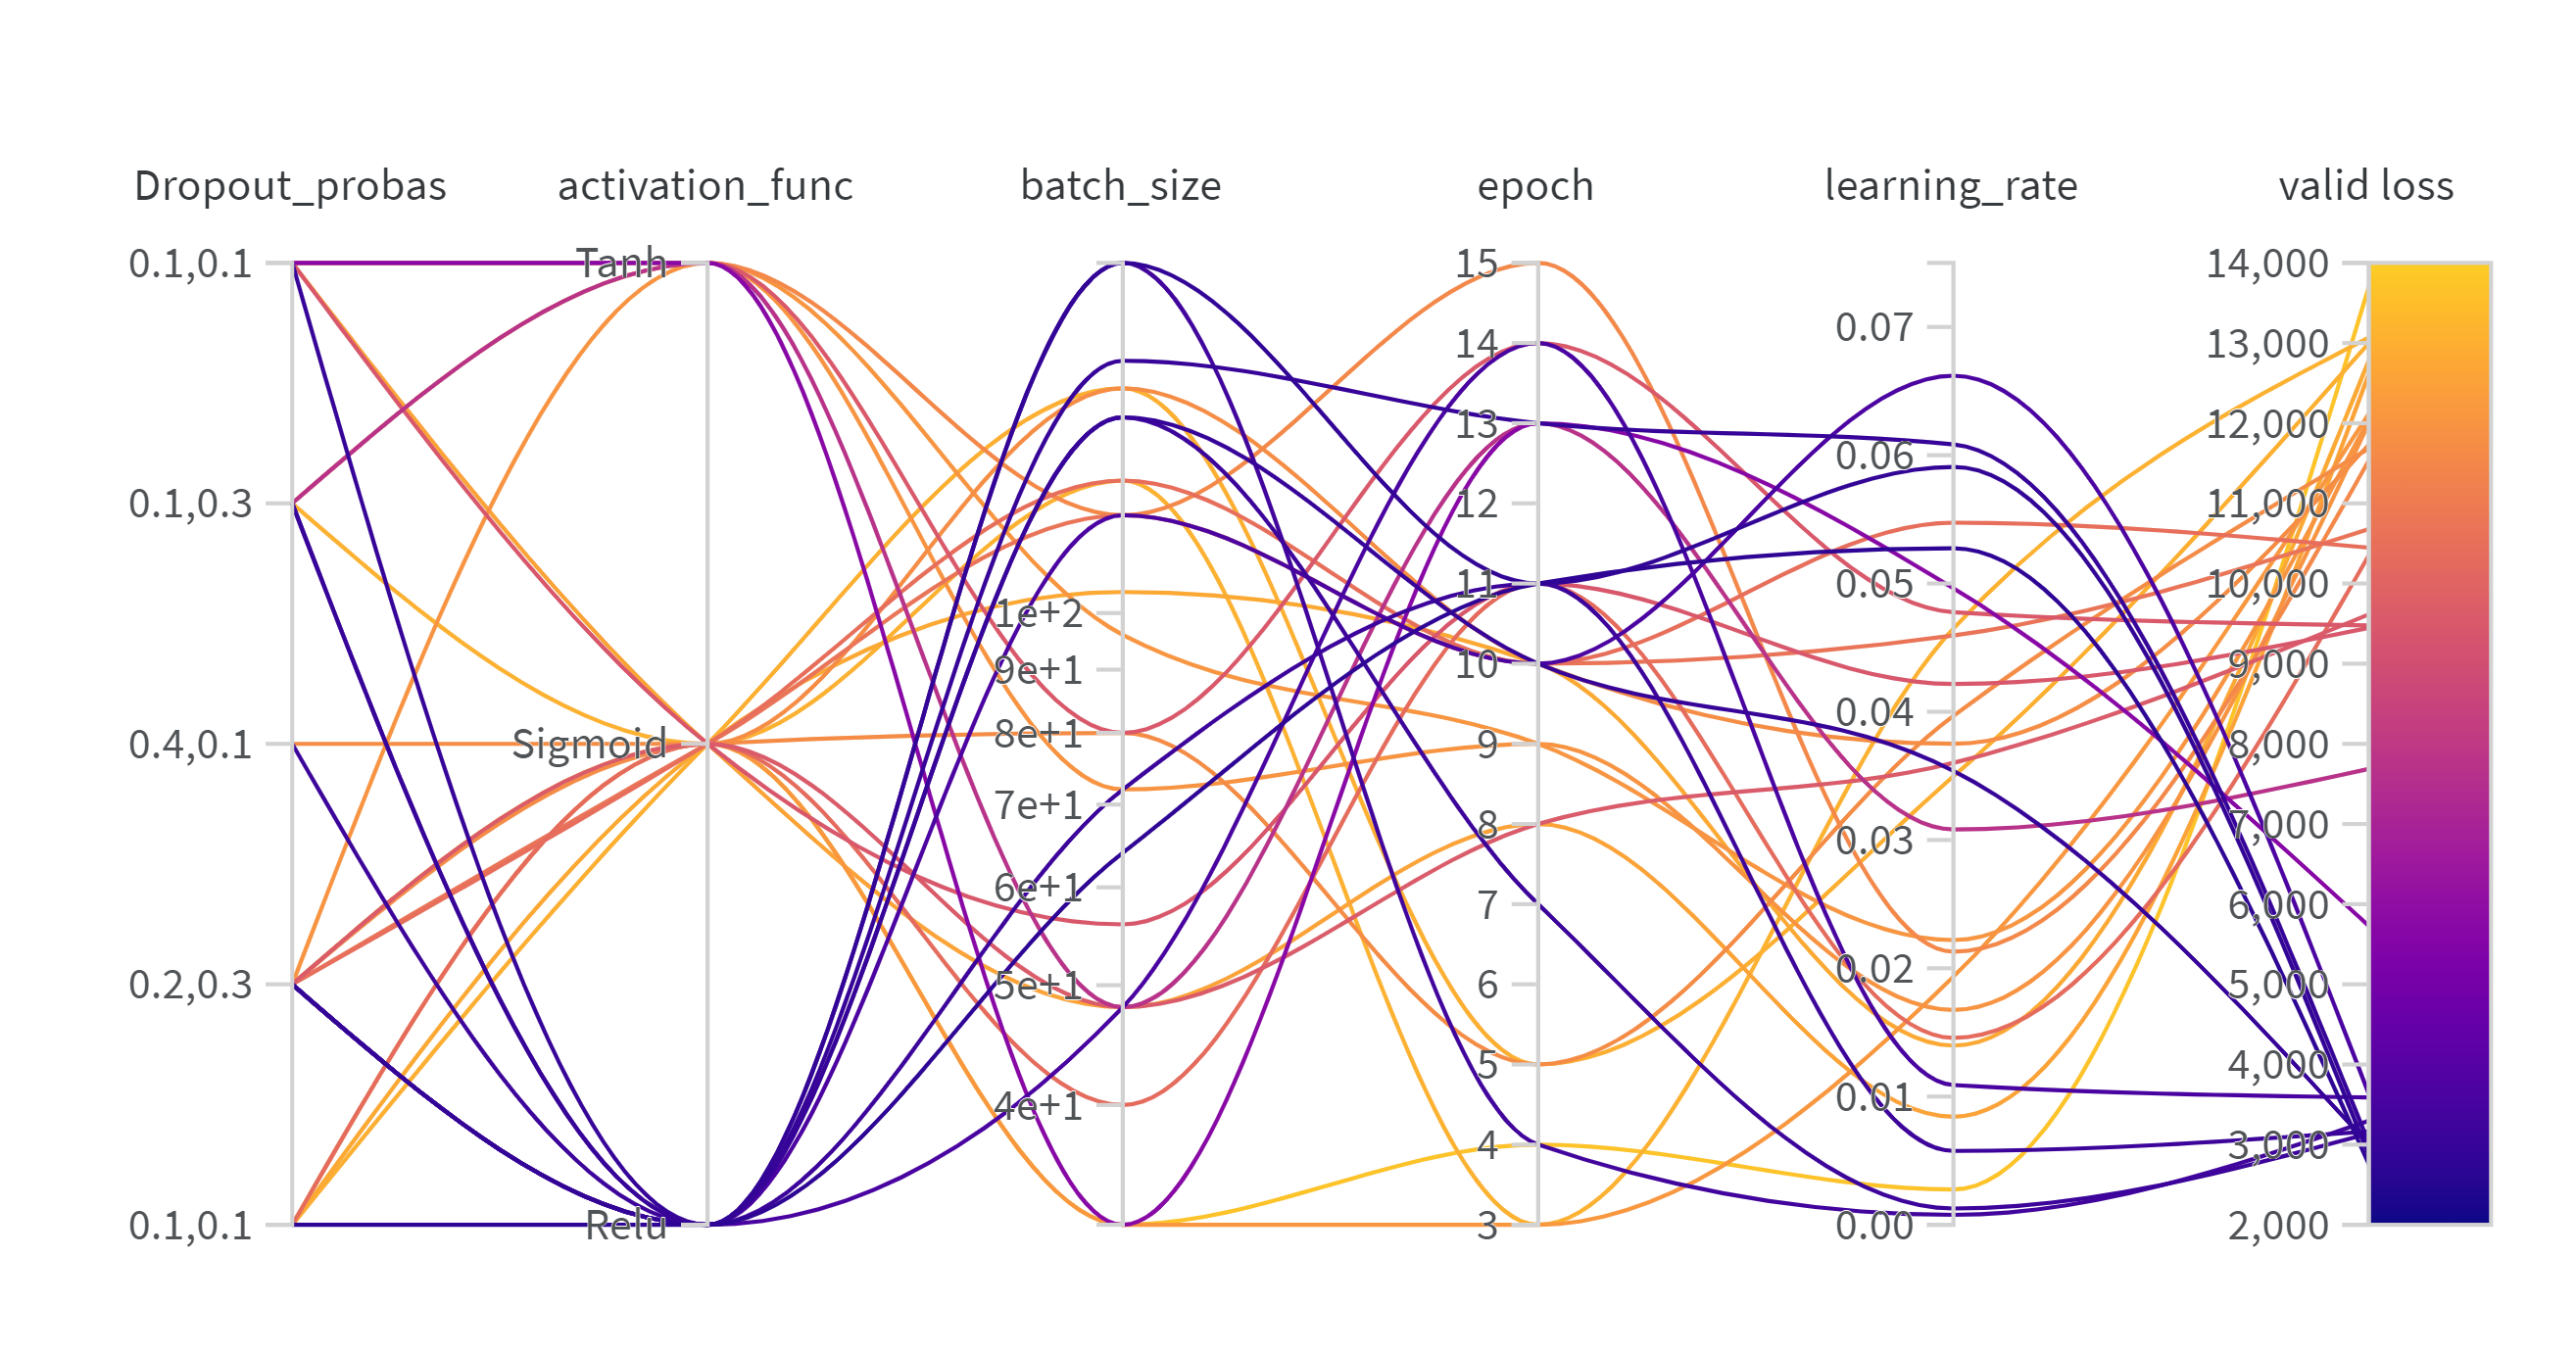

#### **Evaluation of the model**

In [ ]:
best_dropout_probas = [0.1,0.1,0.1,0.1]
best_BATCH_SIZE = 64
best_learning_rate = 0.05274
best_activation_function = "Relu"

# Number of input features
num_features = len(X.columns)
# Total number of layers
num_layers = 5
# Sizes of each layer
layer_sizes = [30, 25, 20, 10]

loss_eval_1 = []
loss_train_1 = []

model = MLP_regression(num_features,
                          num_layers,
                          layer_sizes,
                          best_activation_function,
                          best_dropout_probas)

# Setup loaders
test_loader = DataLoader(test_dataset, batch_size=best_BATCH_SIZE, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=best_BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(eval_dataset, batch_size=best_BATCH_SIZE, shuffle=False)

criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=best_learning_rate)
best_valid_loss = float('inf')

EPOCHS = 20
for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss = train(model, train_loader, optimizer, criterion)
    valid_loss = evaluate(model, valid_loader, criterion)

    loss_eval_1.append(valid_loss)
    loss_train_1.append(train_loss)


    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model, '/content/drive/MyDrive/ML BigProject/model_MLP.pt')
        torch.save(model.state_dict(), '/content/drive/MyDrive/ML BigProject/model_MLP_weights.pt')
        print("---- New best loss ----")
        print("Epoch : ", epoch+1)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

In [ ]:
# Test the model
best_model = torch.load('/content/drive/MyDrive/ML BigProject/model_MLP.pt')
test_loss = evaluate(best_model, test_loader, criterion)
print(f"Test Loss: {test_loss:.3f}")

In [ ]:
# try to train and eval the model without dropout probabilities
best_dropout_probas = [0,0,0,0]
best_BATCH_SIZE = 64
best_learning_rate = 0.05274
best_activation_function = "Relu"

# Number of input features
num_features = len(X.columns)
# Total number of layers
num_layers = 5
# Sizes of each layer
layer_sizes = [30, 25, 20, 10]


loss_eval_2 = []
loss_train_2 = []


model = MLP_regression(num_features,
                          num_layers,
                          layer_sizes,
                          best_activation_function,
                          best_dropout_probas)

# Setup loaders

test_loader = DataLoader(test_dataset, batch_size=best_BATCH_SIZE, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=best_BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(eval_dataset, batch_size=best_BATCH_SIZE, shuffle=False)

criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=best_learning_rate)
best_valid_loss = float('inf')

EPOCHS = 30
for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss = train(model, train_loader, optimizer, criterion)
    valid_loss = evaluate(model, valid_loader, criterion)

    loss_eval_2.append(valid_loss)
    loss_train_2.append(train_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model, '/content/drive/MyDrive/ML BigProject/model_MLP_no_dropout.pt')
        print("---- New best loss ----")
        print("Epoch : ", epoch+1)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

In [ ]:
# Test the model without dropout probabilities
best_model = torch.load('/content/drive/MyDrive/ML BigProject/model_MLP_no_dropout.pt')
test_loss = evaluate(best_model, test_loader, criterion)
print(f"Test Loss: {test_loss:.3f}")

In [ ]:
epochs = range(1, len(loss_eval_1) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_train_1, 'b-', label='Training Loss')
plt.plot(epochs, loss_eval_1, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

epochs = range(1, len(loss_eval_2) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_train_2, 'b-', label='Training Loss')
plt.plot(epochs, loss_eval_2, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Show the best model
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_learning_rate)
print('-------------------- \n',
      'optimizer : ', optimizer, '\n -------------------- \n',
      'criterion : ', criterion, '\n -------------------- \n',
      'model structure : ', best_model, '\n --------------------')

#### Optimisation of the number of layers (Could not run...)

for some reasons, Wandb stopped to work in our code 2 weeks before the deadline. We tried to run it several times without success

In [ ]:
sweep_config = {
    'method': 'random'
    }

metric = {
  'name': 'valid loss',
  'goal': 'minimize'
}

sweep_config['metric'] = metric

parameters_dict = {

    'learning_rate': {
        'distribution' : 'uniform',
        'min' : 2e-2,
        'max' : 0.1,
    },

    "layer_size":{
        'values' : [[30, 25, 20, 10],
                    [30, 25, 20, 15, 10, 5],
                    [30, 28, 25, 20, 5],
                    [20, 15, 8, 5],
                    [25, 20, 5],
                    [28, 20, 18, 10, 5],
                    [10, 15, 20, 25, 30]],
    },
    }


sweep_config['parameters'] = parameters_dict

In [ ]:
best_dropout_probas = [0.1,0.1,0.1,0.1]
best_BATCH_SIZE = 64
best_learning_rate = 0.05274

# Number of input features
num_features = len(X.columns)
# Total number of layers
num_layers = 5
# Sizes of each layer
layer_sizes = [30, 25, 20, 10]


In [ ]:
def wandb_train(config=None):
  with wandb.init(config=config):

    config=wandb.config

    ####### Parameters to swap
    layer_sizes = config.layer_size
    learning_rate = config.learning_rate





    ####### fixed parameters

    # Number of input features
    num_features = len(X.columns)
    # Total number of layers
    num_layers = len(layer_sizes) + 1
    # Batch size
    BATCH_SIZE = 64
    # Dropout probabilities
    Dropout_probas=[0.1,0.1,0.1,0.1]
    # Activation functions
    activation_function = "Relu"



    # Setup loaders
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)


    # Setup the model
    model = MLP_regression(num_features,
                              num_layers,
                              layer_sizes,
                              activation_function,
                              Dropout_probas)

    # Setup criterion and the optimizer
    criterion = torch.nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    EPOCHS = 30
    for epoch in trange(EPOCHS, desc="Epochs"):

        start_time = time.monotonic()

        train_loss = train(model, train_loader, optimizer, criterion)
        valid_loss = evaluate(model, valid_loader, criterion)


        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        wandb.log({"valid loss": valid_loss, "train loss": train_loss, "epoch": epoch})

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="Car_prices_prediction")

In [ ]:
start_time = time.time()
wandb.agent("4wjogn8s", wandb_train, count=60)
elapsed = (time.time() - start_time)/60
print(f'Total Time: {elapsed:.2f} min')

#### Agnostic methods

In [ ]:
background_batches = []
num_background_batches = 10  # Set this to the desired number of batches

for i, data in enumerate(test_loader):
    if i >= num_background_batches:
        break
    if isinstance(data, list) or isinstance(data, tuple):
        # Assuming the first element is the input data
        background_batches.append(data[0])
    else:
        background_batches.append(data)

# Concatenate all the collected batches
background_data = torch.cat(background_batches, dim=0)

# Initialize the SHAP explainer with more background data
explainer = shap.GradientExplainer(best_model, background_data)

# Load multiple batches for test data
test_batches = []
num_test_batches = 10

for i, data in enumerate(test_loader):
    if i >= num_test_batches:
        break
    if isinstance(data, list) or isinstance(data, tuple):
        test_batches.append(data[0])
    else:
        test_batches.append(data)

# Concatenate all the collected test data
test_data = torch.cat(test_batches, dim=0)

# Compute SHAP values
shap_values = explainer.shap_values(test_data)

# Generate the summary plot
shap.summary_plot(shap_values, test_data, feature_names=X.columns)

In [ ]:
# Dependence plot

columns = X.columns
test_data_numpy = test_data.cpu().numpy() if isinstance(test_data, torch.Tensor) else test_data

for col in range(len(columns)):
  print(columns[col])
  shap.dependence_plot(columns[col], shap_values, test_data_numpy, feature_names=X.columns)

#### MLP with PCA components

In [ ]:
y, X = preprocess_Ad_Table_Trim(Ad_table, Trim).final_set(
                standardization=True,
                remove_outliers=True,
                columns_to_drop=columns_to_drop)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)

In [ ]:
pca = PCA()
X_pca = pca.fit_transform(X_train)

In [ ]:
n_components = 11
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

X_test_pca = pca.transform(X_test)

In [ ]:
X_train_pca_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_val_pca_tensor = torch.tensor(X_val_pca, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

X_test_pca_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_dataset_pca = TensorDataset(X_train_pca_tensor, y_train_tensor)
eval_dataset_pca = TensorDataset(X_val_pca_tensor, y_val_tensor)
test_dataset_pca = TensorDataset(X_test_pca_tensor, y_test_tensor)

In [ ]:
# Parameters to swap
BATCH_SIZE = 64
learning_rate = 0.08
EPOCHS = 30
activation_function = "Relu"



# Setup loaders
test_loader = DataLoader(test_dataset_pca, batch_size=BATCH_SIZE, shuffle=False)
train_loader = DataLoader(train_dataset_pca, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(eval_dataset_pca, batch_size=BATCH_SIZE, shuffle=False)

# fixed parameters

# Number of input features
num_features = n_components
# Total number of layers
num_layers = 3
# Sizes of each layer
layer_sizes = [8, 5, 2]
# Dropout probabilities
Dropout_probas=[0,0,0]

best_valid_loss = float('inf')

# Setup the model
model = MLP_regression(num_features,
                          num_layers,
                          layer_sizes,
                          activation_function,
                          Dropout_probas)

# Setup criterion and the optimizer
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss = train(model, train_loader, optimizer, criterion)
    valid_loss = evaluate(model, valid_loader, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model, '/content/drive/MyDrive/ML BigProject/model_MLP_pca.pt')
        torch.save(model.state_dict(), '/content/drive/MyDrive/ML BigProject/model_MLP_weights_pca.pt')
        print("New best model ----")
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print("valid loss : ", valid_loss, "train loss : ", train_loss, "epoch : ", epoch)


In [ ]:
# Test the model with PCA
best_model = torch.load('/content/drive/MyDrive/ML BigProject/model_MLP_pca.pt')
test_loss = evaluate(best_model, test_loader, criterion)
print(f"Test Loss: {test_loss:.3f}")

## Images data

In [ ]:
# Connexion to a device
random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data

In [ ]:
# unpack all images
import shutil
shutil.unpack_archive(filename ='/content/drive/MyDrive/ML BigProject/data/Confirmed_fronts.zip', extract_dir = 'confirmed_fronts')

In [ ]:
autosWithNames = pd.read_csv("/content/drive/MyDrive/ML BigProject/data/autosWithNames.csv", sep=",")

img_dir='confirmed_fronts/'

# Normalize columns names
autosWithNames.rename(columns={'brand': 'Maker',
                               'model_name': 'Genmodel',
                               'model_id': 'Genmodel_ID',
                               'model_year' : 'Year'}, inplace=True)
autosWithNames.drop(columns = 'bodytype', inplace = True)

# Merge price table with the AutoWitgNames table (to make the link with images and give them a price)
df = pd.merge(Price_table, autosWithNames, on=['Maker', 'Genmodel', 'Genmodel_ID', 'Year'], how='inner')




In [ ]:
df['Entry_price'].hist(bins=80)

In [ ]:
df = df[df['Entry_price'] <= 50000]
df['Entry_price'].hist(bins=80)

In [ ]:
nb_train = int(len(df) * 0.7)
nb_valid = int(len(df) * 0.1)
nb_test = int(len(df) * 0.2)


train_data = df[:nb_train] # split the datas into train valid and test
test_data = df[:nb_test]
valid_data = df[:nb_valid]

# Those arent the actual number of images, but the number of different model per dataset. The each model can have different images
len(train_data), len(test_data), len(valid_data)

In [ ]:
# Parameters of images transformation
# those are pretrained mean and stds of the ImageNet dataset
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds = [0.229, 0.224, 0.225]


# Train images transformations
train_transforms = transforms.Compose([
                            transforms.Resize(size=(224,224)),
                            transforms.RandomRotation(degrees=45),
                            transforms.RandomHorizontalFlip(p=0.2),
                            transforms.RandomVerticalFlip(p=0.2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=pretrained_means, std=pretrained_stds)
                                      ])

# Test images transformations

test_transforms = transforms.Compose([
                           transforms.Resize(size=(224,224)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means, std=pretrained_stds),
                                     ])


def get_splitted_data(BATCH_SIZE,
                      train_data,
                      valid_data,
                      test_data,
                      train_transforms,
                      test_transforms):


    # ----------------------------------------------------------------

    # plug train_data in the preprocessing class to get the train_dataset
    train_dataset = DVMdataset(data=train_data,img_dir='confirmed_fronts/',transforms=train_transforms)

    # plug the train_dataset in a DataLoader (then ready to get trained)
    train_loader = DataLoader(dataset=train_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True,
                                drop_last=True)

    # ----------------------------------------------------------------

    # plug valid_data in the preprocessing class to get the valid_dataset
    valid_dataset = DVMdataset(data=valid_data,img_dir='confirmed_fronts/',transforms=test_transforms)
    # Valid dataset is transformed as the test set


    # plug the valid_dataset in a DataLoader
    valid_loader = DataLoader(dataset=valid_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

    # ----------------------------------------------------------------

    # plug test_data in the preprocessing class to get the test_dataset
    test_dataset = DVMdataset(data=test_data,img_dir='confirmed_fronts/',transforms=test_transforms)

    # plug the test_dataset in a DataLoader
    test_loader = DataLoader(dataset=test_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False)

    return train_loader, valid_loader, test_loader, train_dataset, valid_dataset, test_dataset



In [ ]:
train_loader, valid_loader, test_loader, train_dataset, valid_dataset, test_dataset = get_splitted_data(100,
                                                                                                        train_data,
                                                                                                        valid_data,
                                                                                                        test_data,
                                                                                                        None,
                                                                                                        None)


# Print number of images labelled for each dataset
print('Train dataset lenght : ', train_dataset.__len__(), "\n",
      'Valid dataset lenght : ', valid_dataset.__len__(),"\n",
    'Test dataset lenght : ', test_dataset.__len__())

In [ ]:
liste_images = []
liste_prices = []
for i in range(5):
  num = random.randint(1,test_dataset.__len__())
  image = test_dataset.__getitem__(num)
  liste_images.append(image[0])
  liste_prices.append(image[1])

fig, axes = plt.subplots(1, len(liste_images), figsize=(15, 5))

for ax, img, price in zip(axes, liste_images, liste_prices):
    ax.imshow(img)
    ax.axis('off')
    ax.text(0.5, -0.1, f"${price:.2f}", fontsize=12, ha='center', transform=ax.transAxes)

In [ ]:
train_loader, valid_loader, test_loader, train_dataset, valid_dataset, test_dataset = get_splitted_data(100,
                                                                                                        train_data,
                                                                                                        valid_data,
                                                                                                        test_data,
                                                                                                        train_transforms,
                                                                                                        test_transforms)



In [ ]:
liste_images = []
liste_prices = []
for i in range(5):
  num = random.randint(1,train_dataset.__len__())
  image = train_dataset.__getitem__(num)
  liste_images.append(image[0])
  liste_prices.append(image[1])

fig, axes = plt.subplots(1, len(liste_images), figsize=(15, 5))

for ax, img, price in zip(axes, liste_images, liste_prices):
    #ax.imshow(img)
    ax.imshow(img.permute(1, 2, 0))
    ax.axis('off')
    ax.text(0.5, -0.1, f"${price:.2f}", fontsize=12, ha='center', transform=ax.transAxes)

In [ ]:
liste_images = []
liste_prices = []
for i in range(5):
  num = random.randint(1,test_dataset.__len__())
  image = test_dataset.__getitem__(num)
  liste_images.append(image[0])
  liste_prices.append(image[1])

fig, axes = plt.subplots(1, len(liste_images), figsize=(15, 5))

for ax, img, price in zip(axes, liste_images, liste_prices):
    #ax.imshow(img)
    ax.imshow(img.permute(1, 2, 0))
    ax.axis('off')
    ax.text(0.5, -0.1, f"${price:.2f}", fontsize=12, ha='center', transform=ax.transAxes)

### Resnet18 pre-trained model

In [ ]:
 # import resnet18 pretrained model
pretrained_model = models.resnet18(pretrained=True)

# check the last layer input size
number_inputs_last_layer = pretrained_model.fc.in_features
print("Original last layer size : ", pretrained_model.fc)

# change the output size of the last layer, but keep the same number of input
pretrained_model.fc = nn.Linear(number_inputs_last_layer, 1)
print("Transformed last layer size : ", pretrained_model.fc)


In [ ]:
pretrained_model

In [ ]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    model.train()
    for (x, y) in tqdm(iterator, desc="Training", leave=False):
        x = x.to(device)
        y = y.float()
        y = y.to(device)
        y = y.squeeze()

        optimizer.zero_grad()

        y_pred = model(x)

        mse = criterion(y_pred, y)
        loss = torch.sqrt(mse)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    model.eval()
    with torch.no_grad():
        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):
            x = x.to(device)

            y = y.float()
            y = y.to(device)
            y = y.squeeze()

            y_pred = model(x)


            mse = criterion(y_pred, y)
            loss = torch.sqrt(mse)

            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Hyperparameters optimization

In [ ]:
%%capture
!pip install wandb --upgrade
import wandb
wandb.login()

In [ ]:
sweep_config = {
    'method': 'random'
    }

metric = {
  'name': 'valid loss',
  'goal': 'minimize'
}

sweep_config['metric'] = metric

parameters_dict = {

    'learning_rate': {
        'distribution' : 'uniform',
        'min' : 5e-4,
        'max' : 0.07,
    },
    'batch_size' : {
        'distribution': 'q_log_uniform_values',
        'q': 8,
        'min': 30,
        'max': 200,
    },
}

sweep_config['parameters'] = parameters_dict

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="Car_prices_prediction")

In [ ]:
def wandb_train(config=None):
  with wandb.init(config=config):

    config=wandb.config

    learning_rate = config.learning_rate
    BATCH_SIZE = config.batch_size

    train_loader, valid_loader, test_loader, train_dataset, valid_dataset, test_dataset = get_splitted_data(BATCH_SIZE,
                                                                                                            train_data,
                                                                                                            valid_data,
                                                                                                            test_data,
                                                                                                            train_transforms,
                                                                                                            test_transforms)
    # import resnet50 pretrained model
    pretrained_model = models.resnet18(pretrained=True)

    # check the last layer input size
    number_inputs_last_layer = pretrained_model.fc.in_features

    # change the output size of the last layer, but keep the same number of input
    pretrained_model.fc = nn.Linear(number_inputs_last_layer, 1)
    pretrained_model.fc



    optimizer = optim.Adam(pretrained_model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    model = pretrained_model.to(device)
    criterion = criterion.to(device)

    EPOCHS = 2
    for epoch in trange(EPOCHS, desc="Epochs"):

        start_time = time.monotonic()

        train_loss = train(model, train_loader, optimizer, criterion, device)
        valid_loss = evaluate(model, valid_loader, criterion, device)


        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        wandb.log({"valid loss": valid_loss, "train loss": train_loss, "epoch": epoch})

In [ ]:

start_time = time.time()
wandb.agent("h4p30t8g", wandb_train, count=40)
elapsed = (time.time() - start_time)/60
print(f'Total Time: {elapsed:.2f} min')

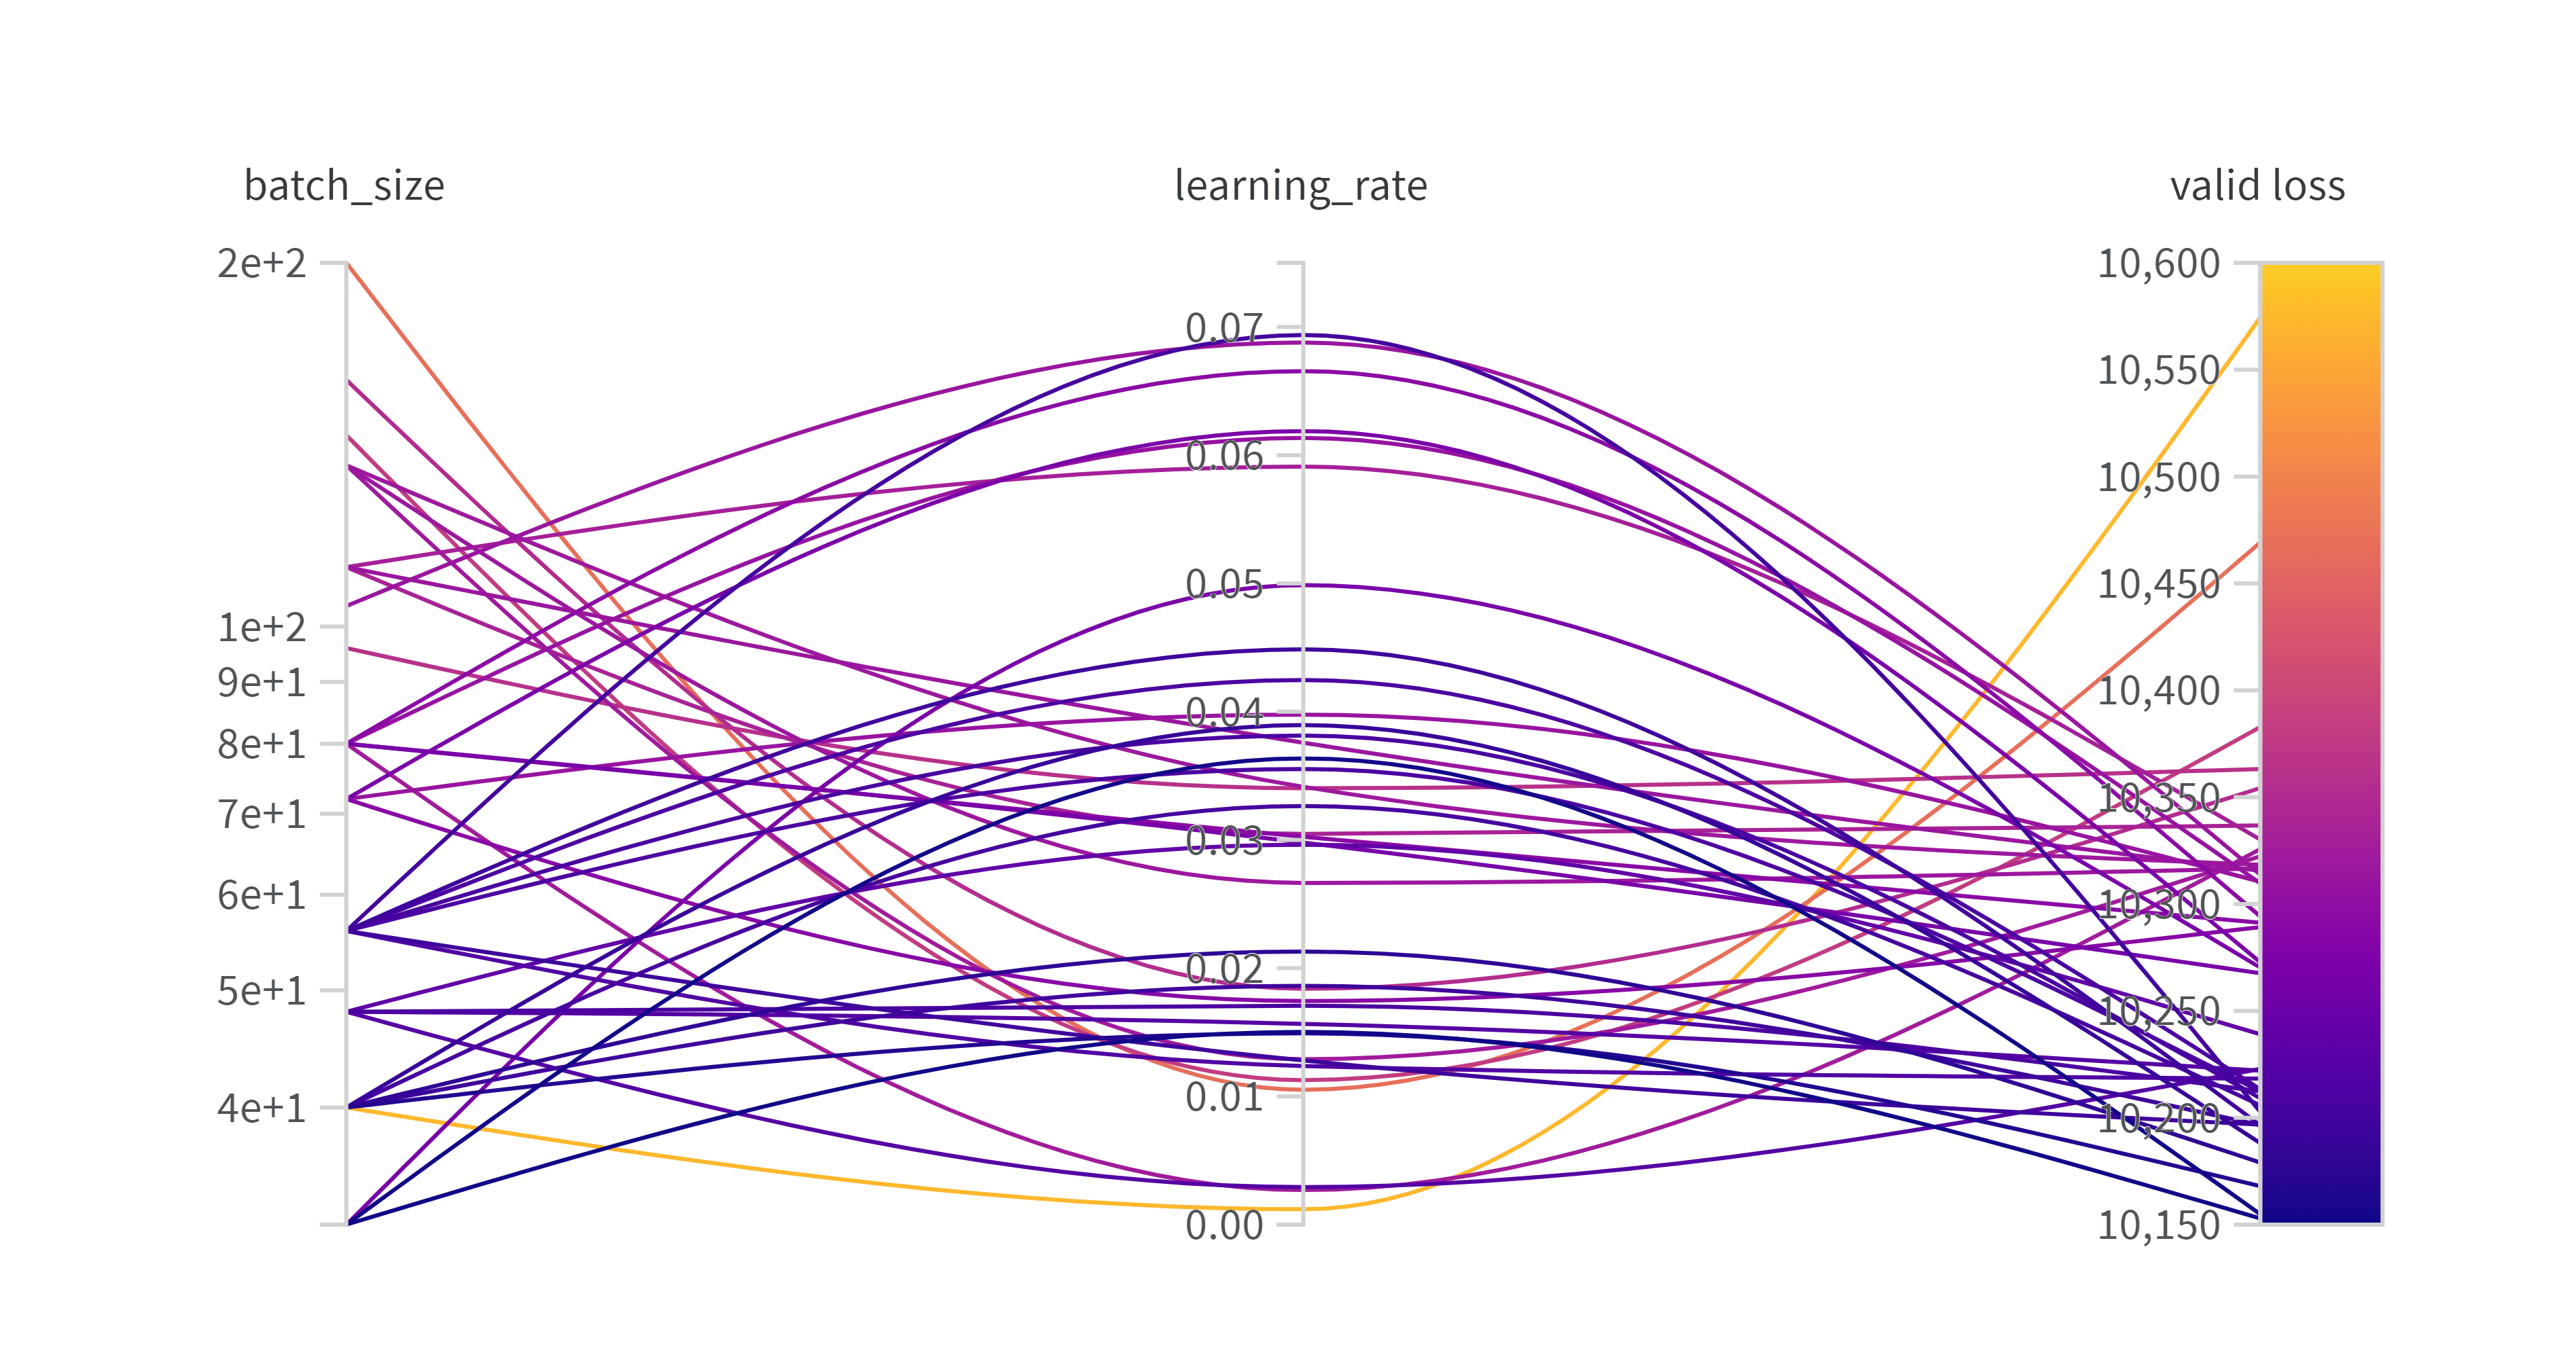

In [ ]:
# check the last layer input size
number_inputs_last_layer = pretrained_model.fc.in_features

# change the output size of the last layer, but keep the same number of input
pretrained_model.fc = nn.Linear(number_inputs_last_layer, 1)
pretrained_model.fc

best_batch_size = 32
best_learning_rate = 0.01503

model = pretrained_model.to(device)

optimizer = optim.Adam(pretrained_model.parameters(), lr=best_learning_rate)

criterion = nn.MSELoss()
criterion = criterion.to(device)

train_loader, valid_loader, test_loader, train_dataset, valid_dataset, test_dataset = get_splitted_data(best_batch_size,
                                                                                                            train_data,
                                                                                                            valid_data,
                                                                                                            test_data,
                                                                                                            train_transforms,
                                                                                                            test_transforms)
best_valid_loss = float('inf')
EPOCHS = 3
for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss = train(model, train_loader, optimizer, criterion, device)
    valid_loss = evaluate(model, valid_loader, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model, '/content/drive/MyDrive/ML BigProject/model_CNN.pt')
        torch.save(model.state_dict(), '/content/drive/MyDrive/ML BigProject/model_CNN_weights.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

In [ ]:
                      # check the last layer input size
number_inputs_last_layer = pretrained_model.fc.in_features

# change the output size of the last layer, but keep the same number of input
pretrained_model.fc = nn.Linear(number_inputs_last_layer, 1)
pretrained_model.fc

best_batch_size = 32
best_learning_rate = 0.01503

model = pretrained_model.to(device)

optimizer = optim.Adam(pretrained_model.parameters(), lr=best_learning_rate)

criterion = nn.MSELoss()
criterion = criterion.to(device)

loss_eval_1 = []
loss_train_1 = []




train_loader, valid_loader, test_loader, train_dataset, valid_dataset, test_dataset = get_splitted_data(best_batch_size,
                                                                                                            train_data,
                                                                                                            valid_data,
                                                                                                            test_data,
                                                                                                            train_transforms,
                                                                                      test_transforms)
best_valid_loss = float('inf')
EPOCHS = 6
for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss = train(model, train_loader, optimizer, criterion, device)
    valid_loss = evaluate(model, valid_loader, criterion, device)
    loss_eval_1.append(valid_loss)
    loss_train_1.append(train_loss)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model, '/content/drive/MyDrive/ML BigProject/model_CNN.pt')
        torch.save(model.state_dict(), '/content/drive/MyDrive/ML BigProject/model_CNN_weights.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

### Test of the model

In [ ]:
# Test the model
best_model_CNN = torch.load('/content/drive/MyDrive/ML BigProject/model_CNN.pt', map_location=torch.device("cpu"))
test_loss = evaluate(best_model_CNN, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.3f}")

In [ ]:
epochs = range(1, len(loss_eval_1) + 1)
# Plotting the training and validation loss of the CNN
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_train_1, 'b-', label='Training Loss')
plt.plot(epochs, loss_eval_1, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()